README: The scripts below used to build the basic pipeline of classification modeling. <br>
- manually setting threshold based on probability of each class predicted by different modeling methods, e.g., LogisticRegression(), MultiNomial(),etc.
- reformatted based on basic_pipeline_setup_v5.ipynb
- combined in usage with modeling_main.py

In [1]:
import pandas as pd
import os
os.chdir('/Users/liyuan/desktop/CSAir/codes')
import numpy as np
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB  
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from modeling_main import ReviewClassify
from tokenization import Tokenization
from help import get_tokenized_sent, get_stopwords

Using TensorFlow backend.


In [1]:
## task: preprocess data to include untokenized user reviews (finished)
# data preprocess again (include the untokenized review)
all_raw_labeled_data = pd.read_csv('../res/all_raw_labeled_data.csv')
print(len(all_raw_labeled_data))
reviews = all_raw_labeled_data.review.values
print(len(reviews))
all_raw_labeled_data['review_tokens'] = all_raw_labeled_data['review'].apply(get_tokenized_sent)
all_raw_labeled_data
# reorder columns 
all_raw_labeled_data = all_raw_labeled_data[['review','review_tokens','label','label_encoded']]
all_raw_labeled_data.head()
# output to csv file
# all_raw_labeled_data.to_csv('../res/labeled_data_with_without_tk.csv', index = False)

NameError: name 'pd' is not defined

training data has 1038 examples
test data has 512 examples
there are 10 classes
there are only 424 user reviews picked by classes after manual setting threshold


,index,review,review_tokens,label,label_encoded,labels_predicted
0,0,行李箱丢了！在荷兰机场语言不通，你们航空公司也没个人来管事，解释！,行李箱 丢 荷兰 机场 语言不通 航空公司 管事 解释,到达,2,[1]
1,1,昨晚（11月11日）我搭乘cz8278次18:25长沙飞海口的航班，飞机下降临近海口时，我突...,昨晚 月 日 搭乘 cz 次 长沙 飞 海口 航班 飞机 下降 临近 海口 时 突发...,到达,2,[5]
2,2,延误能不能早点通知，我就好修改航班，下午16点到机场，延误就早点通知，我就能修改18点的航班...,延误 早点 通知 修改 航班 下午 点到 机场 延误 早点 通知 修改 点 航班 延误 ...,中转,0,"[0, 1]"
3,3,严重晚点,晚点,中转,0,"[1, 2]"
4,4,我在网上补登里程、只能䃼登上9月24日南京-广州、国际段䃼登不上、麻烦处理一下。 zhu n...,网上 补登 里程 只能 䃼 登上 月 日 南京 广州 国际 段 䃼 登不上 麻烦 zh...,售后,3,[3]


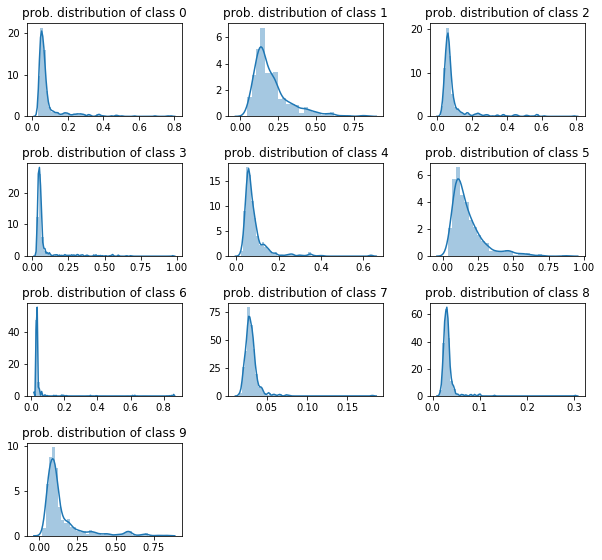

In [2]:
## modeling: logistic regression
rc = ReviewClassify(LogisticRegression())
class_reviews_dct_lg = rc.classify_reviews('../res/labeled_data_with_without_tk.csv')
# reverse key-value result in class_reviews_dct 
# keys are indices of user reviews in test data, values are the predicted "high-proba" labels associated
review_label_lg = rc.reformat_review_label(class_reviews_dct_lg)

# add predicted labels as new column in test_data dataframe
joined_test_data = rc.add_pred_to_data()
joined_test_data.head()

In [3]:
# checking
print('user review indices (in test data) picked by class 0:', class_reviews_dct_lg[0])
# different from original indices in the entire dataset

# more checking 
print('"high-probability" labels of user review (index=2 positioned in test data):', review_label_lg[2])

user review indices (in test data) picked by class 0: [2, 5, 6, 26, 51, 62, 68, 69, 130, 143, 191, 206, 224, 226, 227, 230, 244, 246, 248, 279, 304, 307, 308, 310, 339, 343, 356, 361, 362, 374, 387, 404, 407, 411, 419, 432, 436, 450, 452, 456, 458, 459, 470, 477, 483, 488, 493, 508]
"high-probability" labels of user review (index=2 positioned in test data): [0, 1]


In [9]:
# reference of label encodings
rc.labels_index

{'计划': 7,
 '机上': 5,
 '中转': 0,
 '售后': 3,
 '预订': 9,
 '设计': 8,
 '出发': 1,
 '性能': 4,
 '行程': 6,
 '到达': 2}

In [8]:
## task: find the reviews assigned to multiple labels
indices_with_multiple_labels = rc.get_review_with_multiple_labels(threshold = 1)

# get subset dataframe by indices with multiple labels
data_multiple_labels = rc.get_review_data_with_multiple_labels(indices_with_multiple_labels)

# output results to csv file
data_multiple_labels = data_multiple_labels.drop(columns = ['index'])
data_multiple_labels.to_csv('../res/reviews_with_multiple_labels_lg.csv', index = False)

indices with multiple labels: [2, 5, 26, 51, 62, 130, 143, 191, 206, 226, 246, 307, 356, 361, 362, 374, 404, 419, 432, 452, 456, 458, 459, 477, 483, 493, 508, 3, 21, 52, 64, 67, 175, 188, 196, 229, 245, 317, 333, 341, 344, 347, 367, 385, 422, 446, 461, 478, 12, 352, 438, 71, 145, 243, 280, 282, 327, 412, 434, 482, 53, 74, 116, 202, 220, 285, 328, 330, 331, 342, 378, 395, 409, 428, 448, 449, 462, 492, 495, 271, 309, 322, 390, 400, 16, 109, 135, 414, 48, 354, 418]


In [22]:
## task: get reviews without any labels picked
# joined_test_data
data_no_labels = joined_test_data[joined_test_data.isnull().any(axis=1)]
data_no_labels = data_no_labels.drop(columns = ['index'])
data_no_labels.to_csv('../res/reviews_with_no_labels_lg.csv', index = False)

In [ ]:
# check results by common sense

In [ ]:
# TODO: Naive Bayes